In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
#features 
features_file = '/home/mat/eeg_epilepsy/filtered_demo_epilepsy.csv'
# participant_file='/home/mat/projects/def-kjerbi/cocolab_data/EEG_ADHD_epilepsy_psychostimulants/BIDS/participants.tsv'
# Read CSV into a DataFrame
features = pd.read_csv(features_file)

features_ending_with_C3 = {col[:-2] for col in features.columns if col.endswith('C3')}

# Remove 'A1' from each column name and create a new list
feature_names = list(features_ending_with_C3)

print("number of features:", len(feature_names), "names: ", feature_names)
suffixes_set = {col[-2:] for col in features.columns if col.startswith("feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'beta').spaces-")}

# Convert to list (optional - sets are unordered)
sensor_names = list(suffixes_set)
print("#sensors: ", len(sensor_names), "sensor names: ", sensor_names)



# participants_df = pd.read_csv(participant_file, sep='\t')
#select that don't have autism or adhd 
# participants = participants_df[(participants_df['ADHD'] == '0') & (participants_df['Autism'] == '0')]

# remove duplicates
# participants_relevant = participants[['participant_id', 'age', 'sex', 'Epilepsy', 'Psychostimulant']]
#select feature

number of features: 67 names:  ['feature-RelativeBandPowerFromAverageFooof.bands-beta.spaces-', "feature-BandRatiosFromAverageSpectrum.bands_pairs-('gamma', 'theta').spaces-", 'feature-lzivComplexityMeanEpochs.spaces-', "feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'alpha').spaces-", 'feature-hjorthComplexityMeanEpochs.spaces-', "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'beta').spaces-", 'feature-katzFdSDEpochs.spaces-', 'feature-petrosianFdMeanEpochs.spaces-', 'feature-entropyMultiscaleMeanEpochs.spaces-', "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-", "feature-BandRatiosFromAverageSpectrum.bands_pairs-('delta', 'beta').spaces-", "feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'delta').spaces-", 'feature-higuchiFdMeanEpochs.spaces-', 'feature-katzFdMeanEpochs.spaces-', "feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'theta').spaces-", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'gamma').spaces-

2. LR grouped by sensor doesnt yield any significant feature importance


In [13]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression


sensors_df = pd.DataFrame(columns=['feature_name', 'intercept', 'coefficients', 
                                 'accuracy', 'mse'])

for sensor in sensor_names:
    X = features.loc[:, features.columns.str.endswith(sensor) | (features.columns == "Epilepsy")]
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X = X.dropna()
    y = X["Epilepsy"]
    X = X.drop(columns =["Epilepsy"])  
    filtered_cols = [col for col in X.columns if "bands_pairs" in col]
    X = X[filtered_cols]

    y = y.replace('0 (potentiel)', '0')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    sensor_names = [col for col in X.columns]   
    intercept = model.intercept_
    coefficients = model.coef_[0]
    sensors_df.loc[len(sensors_df)] = {
    'feature_name': sensor,
    'intercept': intercept ,
    'coefficients': coefficients,
    'accuracy': accuracy,
    'mse': mse
}

3. Logistic Regression results per each feature:

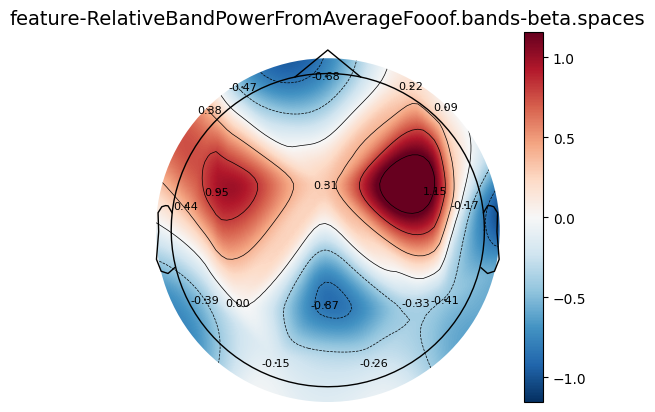

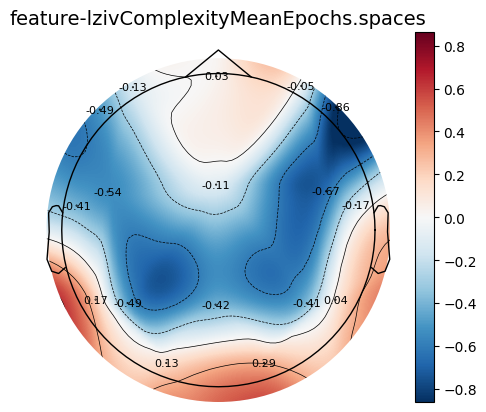

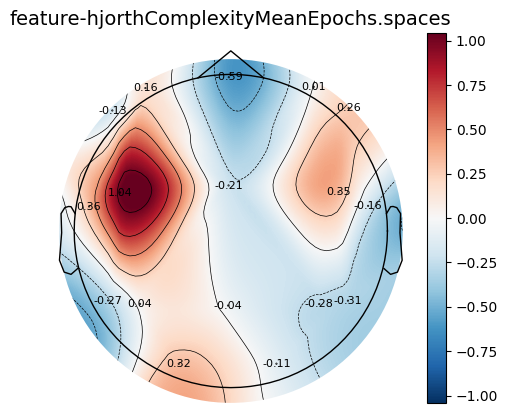

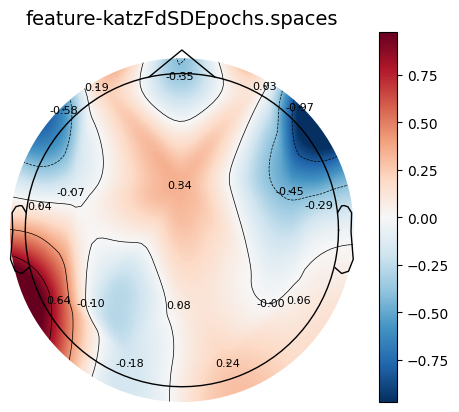

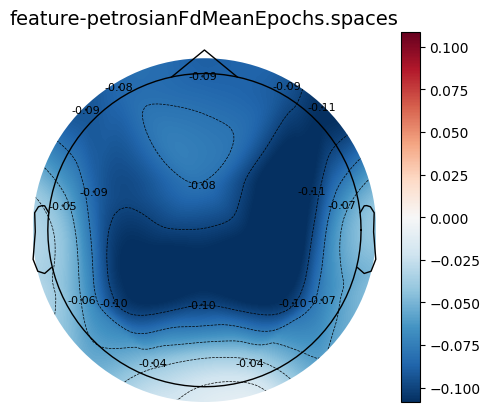

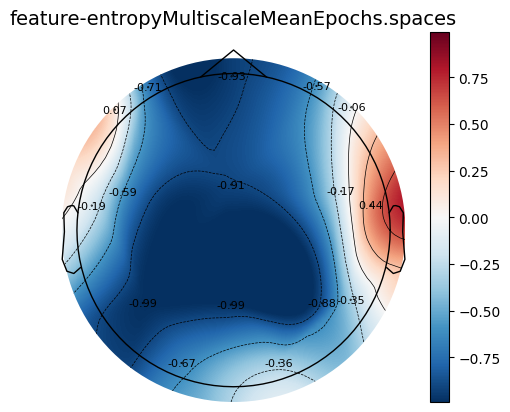

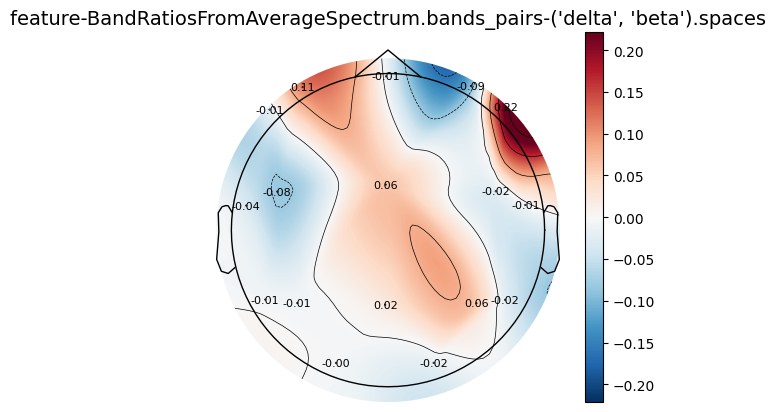

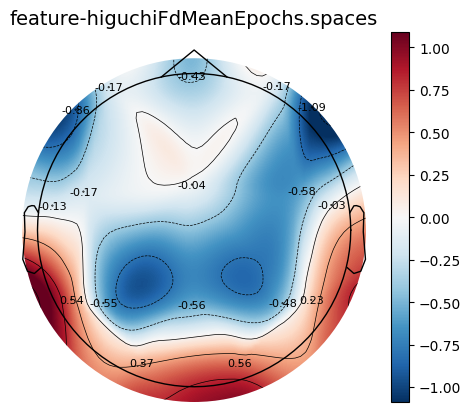

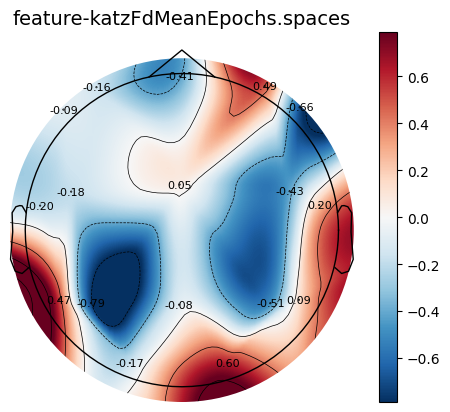

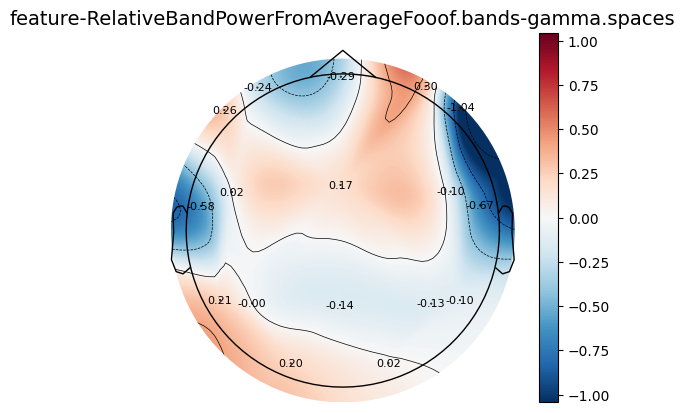

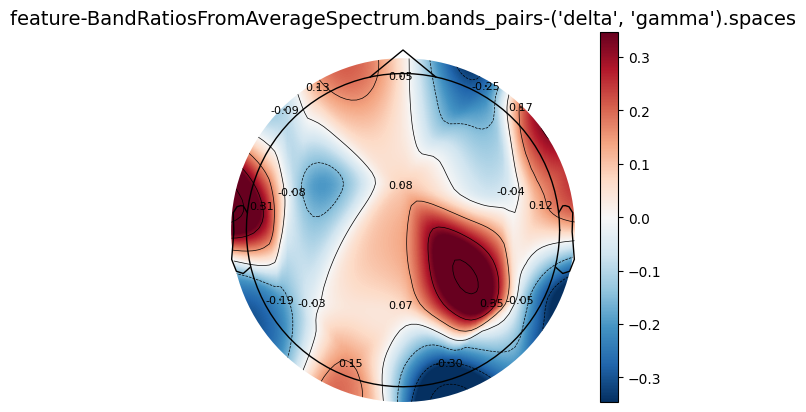

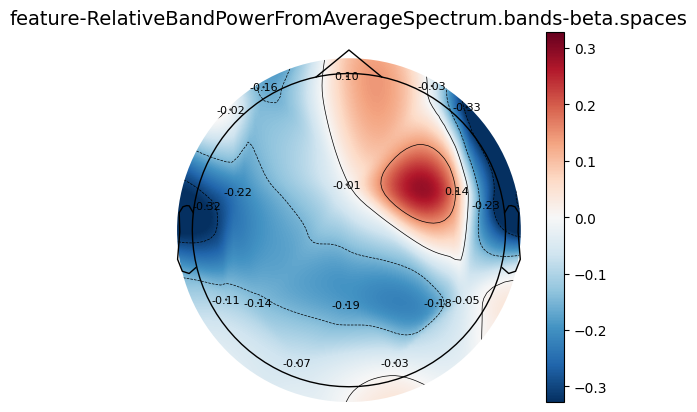

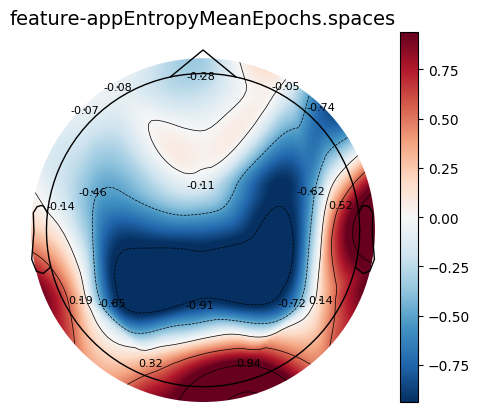

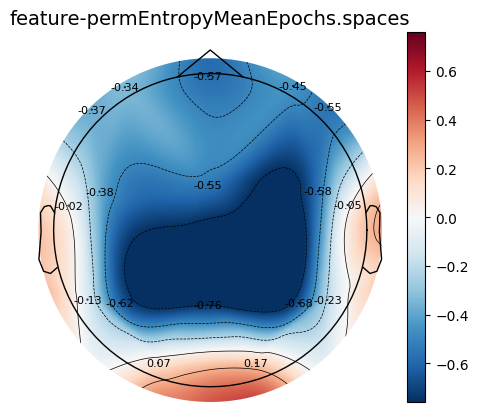

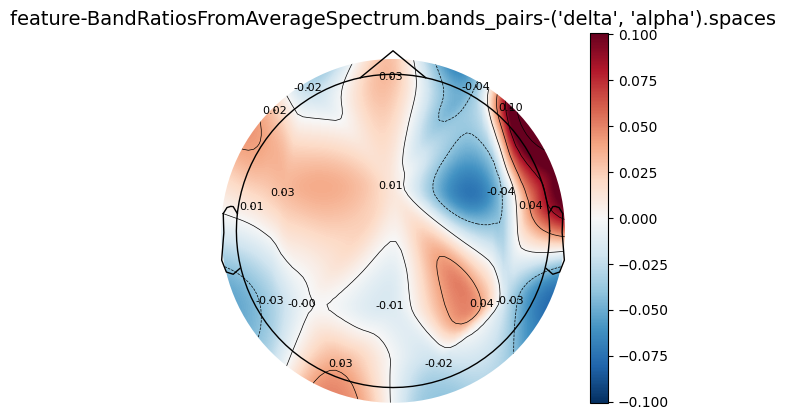

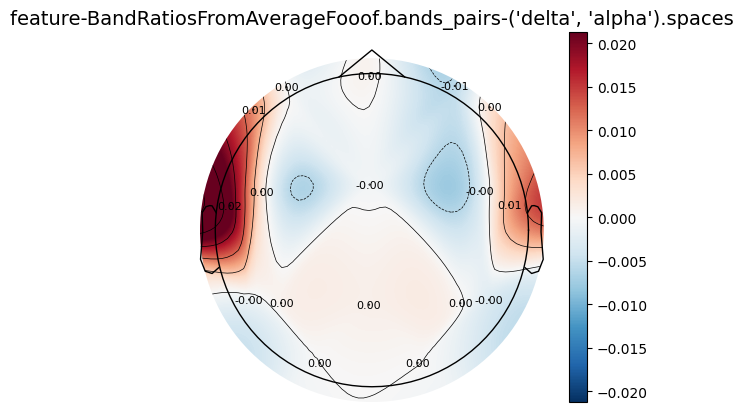

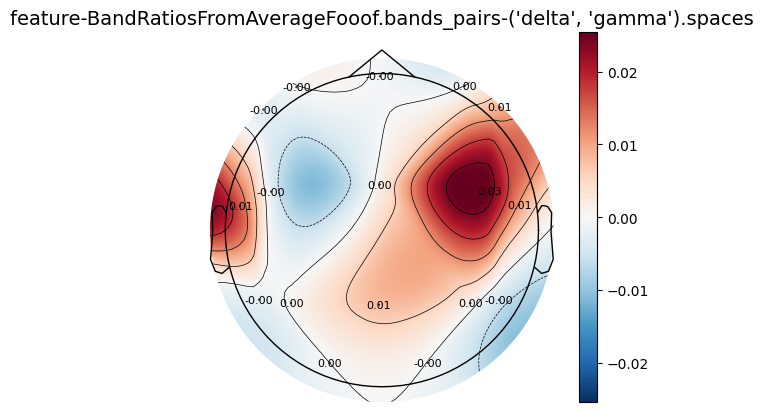

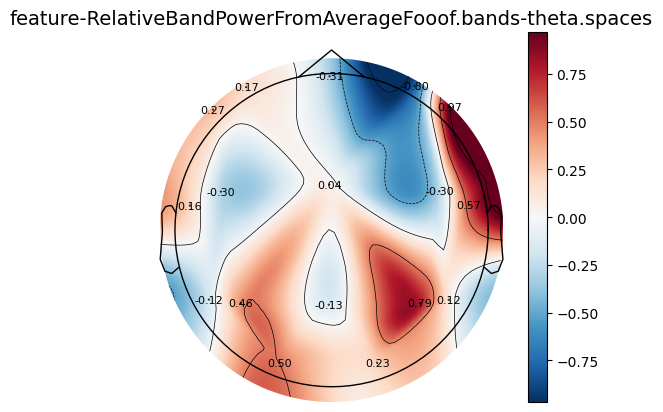

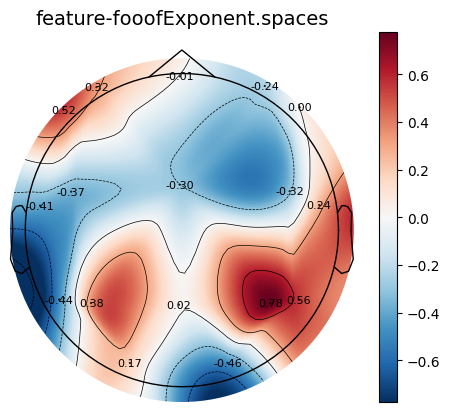

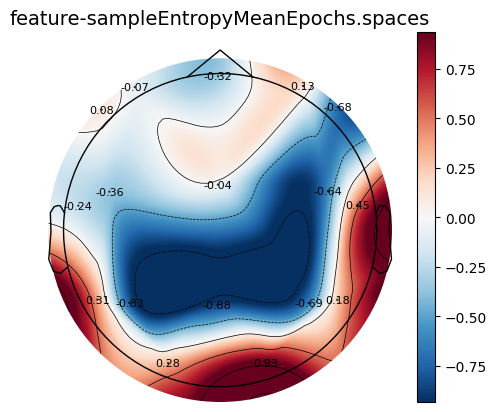

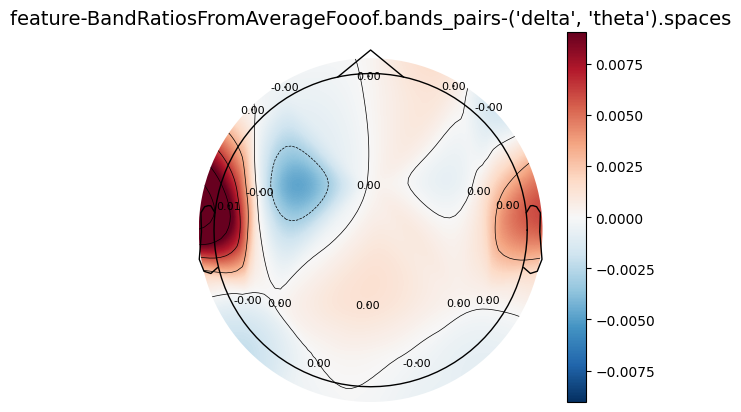

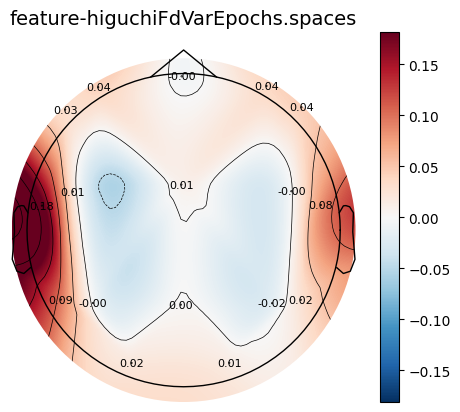

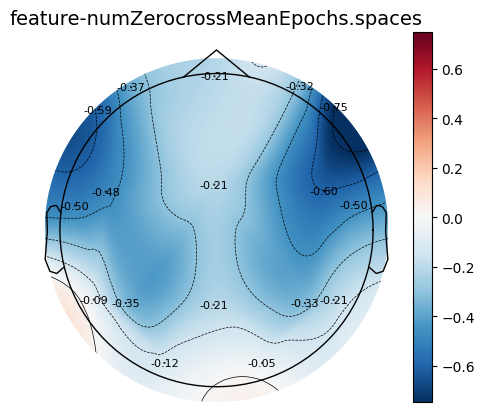

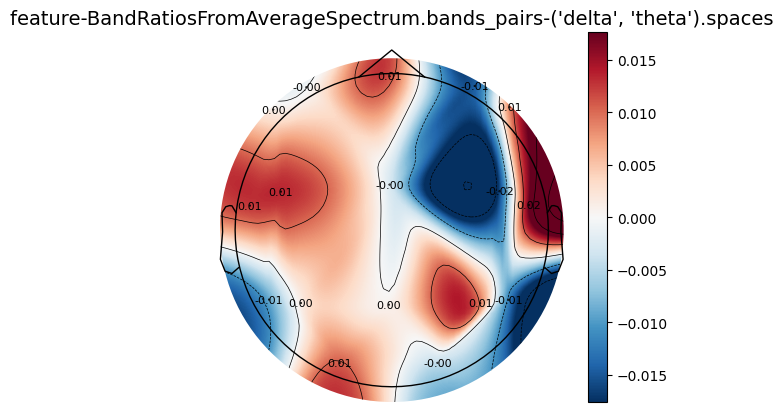

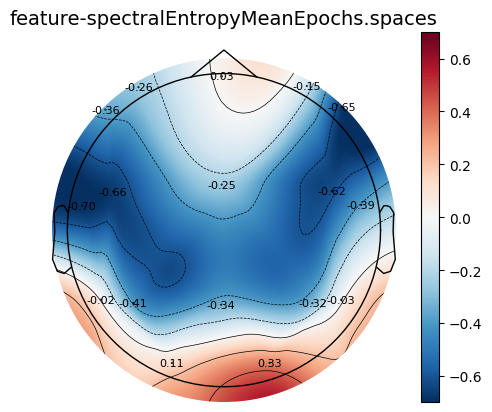

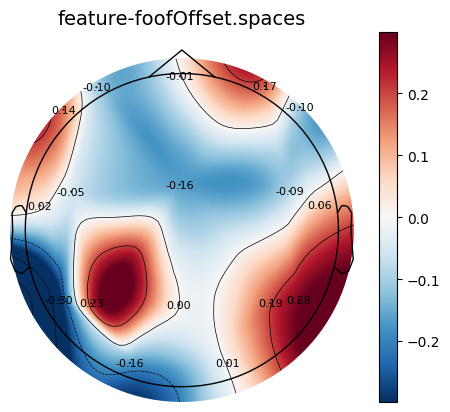

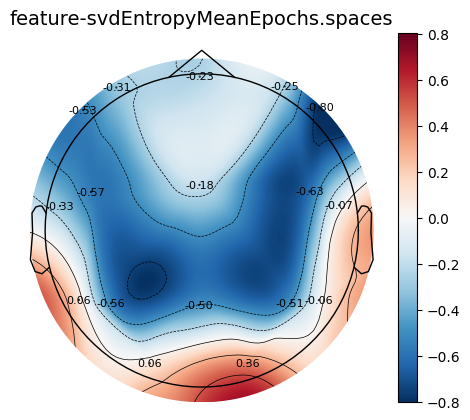

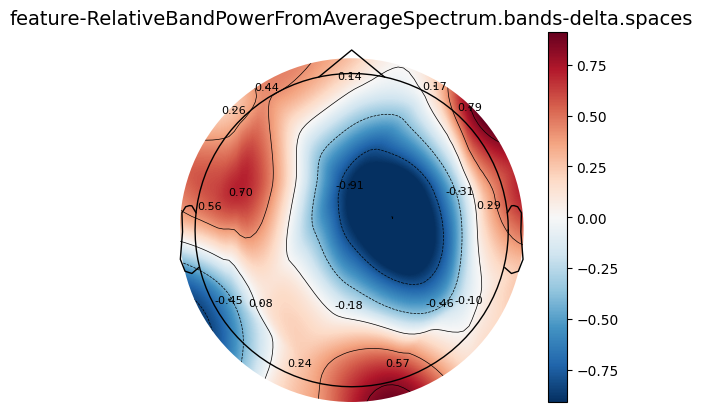

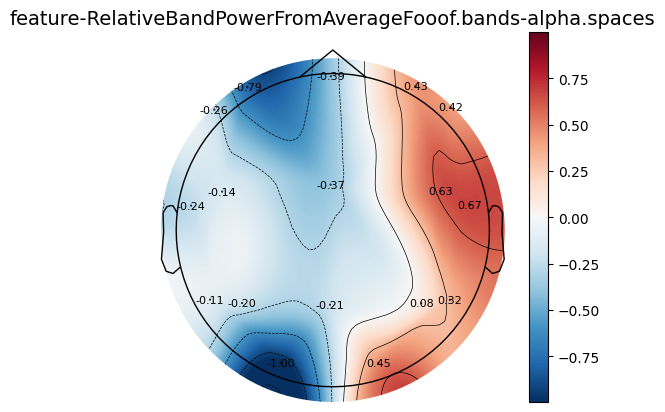

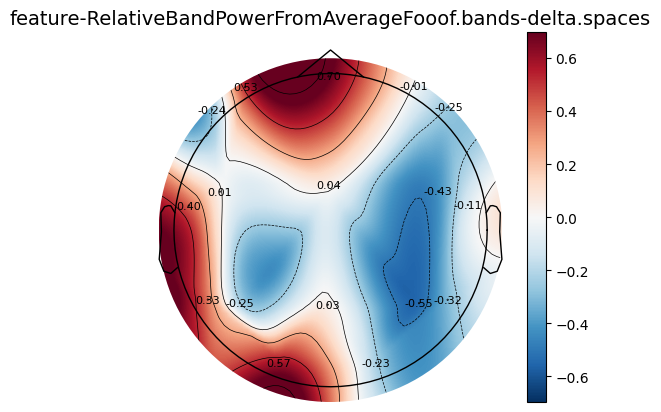

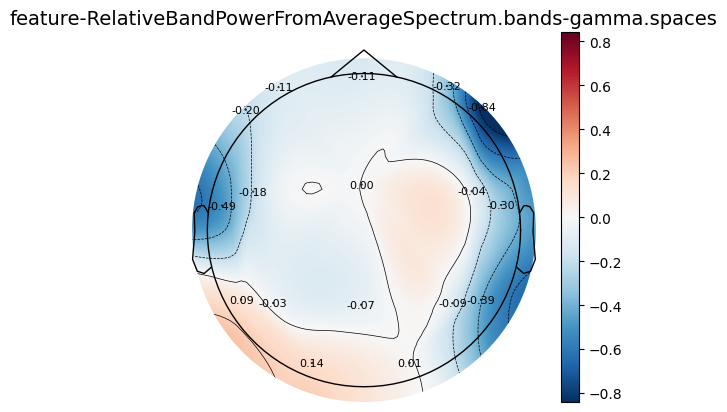

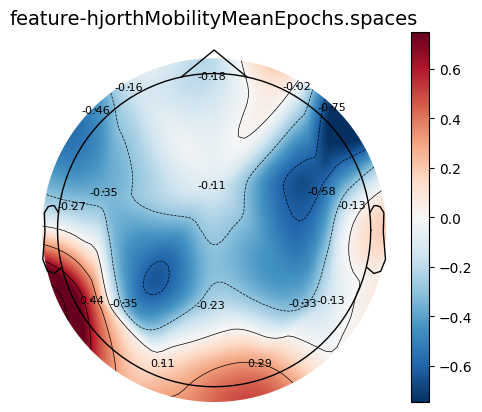

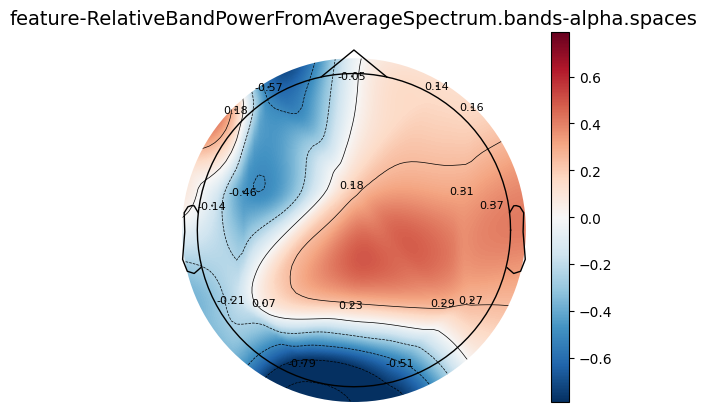

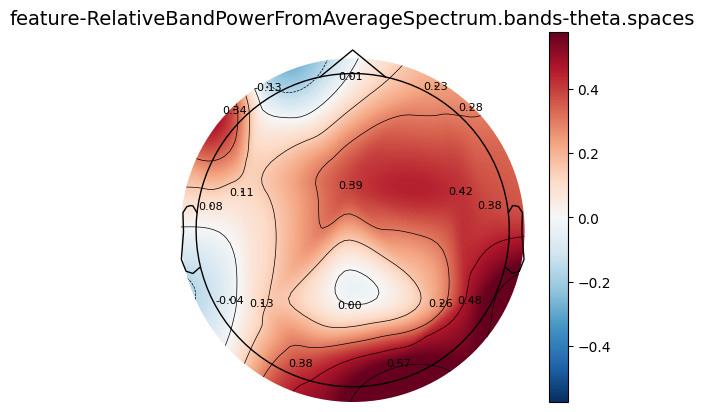

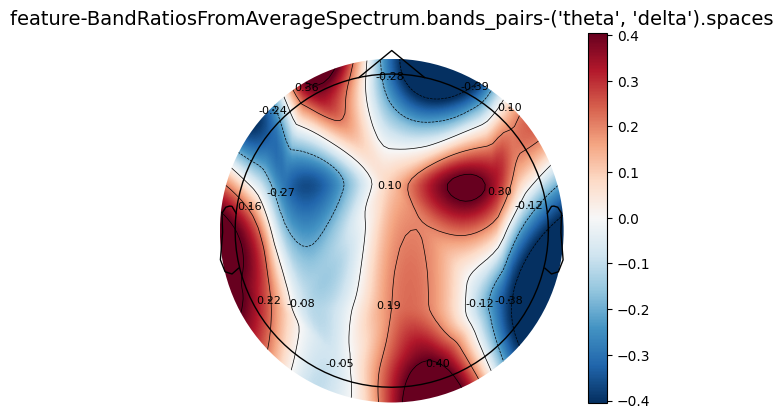

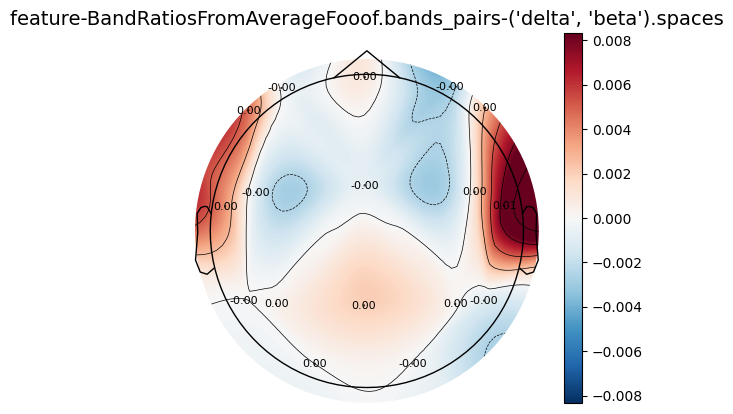

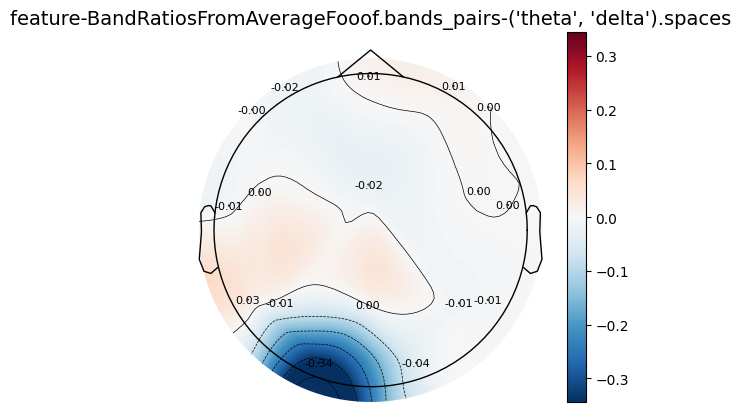

30
["feature-BandRatiosFromAverageSpectrum.bands_pairs-('gamma', 'theta').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'alpha').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'beta').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'delta').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('gamma', 'theta').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'gamma').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('theta', 'beta').spaces", "feature-BandRatiosFromAverageSpectrum.bands_pairs-('beta', 'delta').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('beta', 'delta').spaces", "feature-BandRatiosFromAverageSpectrum.bands_pairs-('alpha', 'beta').spaces", "feature-BandRatiosFromAverageSpectrum.bands_pairs-('alpha', 'gamma').spaces", "feature-BandRatiosFromAverageFooof.bands_pairs-('beta', 'alpha').spaces", "f

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
import mne
from matplotlib import pyplot as plt
from mne.channels import make_standard_montage  
from mne.viz import plot_topomap  


results_df = pd.DataFrame(columns=['feature_name', 'intercept', 'coefficients', 
                                 'accuracy', 'mse'])

zero_coeff = []
for name in feature_names:
    X = features.loc[:, features.columns.str.startswith(name) | (features.columns == "Epilepsy")]
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X = X.dropna()
    y = X["Epilepsy"]
    # p2, p1 dont exist int the montage couldn't match them. 
    columns_to_drop = [col for col in X.columns if col.endswith(('p2', 'p1','.1'))]
    X = X.drop(columns = columns_to_drop)  
    X = X.drop(columns =["Epilepsy"])  
    X.columns = [col[-2:] for col in X.columns]

    y = y.replace('0 (potentiel)', '0')
    model = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    sensor_names = [col for col in X.columns]   
    intercept = model.intercept_[0]
    coefficients = model.coef_[0]
    results_df.loc[len(results_df)] = {
    'feature_name': name,
    'intercept': intercept if abs(intercept) > 1e-8 else 0,
    'coefficients': coefficients,
    'accuracy': accuracy,
    'mse': mse
}

    if not np.all(coefficients == 0):

        data = coefficients[:, np.newaxis]
        info = mne.create_info(ch_names=sensor_names, sfreq=250.0, ch_types='eeg')
        montage = make_standard_montage('standard_1020')
        info.set_montage(montage)
        pos = mne.find_layout(info).pos  
        ch_pos = {ch: info['chs'][i]['loc'][:2] for i, ch in enumerate(info['ch_names'])}

        # Create pos array (x, y) coordinates
        pos_2d = np.array([ch_pos[ch] for ch in sensor_names])

        # Plot the topomap
        fig, ax = plt.subplots()
        im, _ = plot_topomap(
            data=coefficients,
            pos=pos_2d,
            axes=ax,
            cmap='RdBu_r',
            show=False,
            vlim=(-np.max(np.abs(coefficients)), np.max(np.abs(coefficients)))
        )

        # Add coefficient value annotations
        for (x, y), val in zip(pos_2d, coefficients):
            if val != 0:
                ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

        ax.set_title(name[:-1], fontsize=14)
        plt.colorbar(im, ax=ax)
        plt.show()
    else:
        zero_coeff.append(name[:-1])
print(len(zero_coeff))
print(zero_coeff)
results_df.to_csv('lr_per_feature.csv', index=False)


    


3. Debugging to understand why the logistic regression model wasn't learning 

In [30]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.preprocessing import RobustScaler
# from collections import Counter

# threshold = 1e10

# name1= "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces"
# name2= "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'beta').spaces-"
# # merge dfs 
# X = features.loc[:, features.columns.str.startswith(name1) | (features.columns == "Epilepsy")]
# X_clean = X.copy()  # Explicit copy to avoid warnings
# X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
# X_clean = X_clean.dropna(axis=1, how='all')  # Drop columns where ALL values are nan
# X_clean = X_clean.dropna(axis=0)            # Drop rows where ANY value is nan

# # 3. Calculate variances and identify bad features
# variances = X_clean.var(numeric_only=True)  # Only numeric columns
# bad_features_mask = variances.isna() | (variances == 0) | variances.isin([np.inf, -np.inf])

# print(f"Dropping {bad_features_mask.sum()} bad features:")
# print(variances[bad_features_mask].index.tolist())  # Show which features are being dropped

# # 4. Keep only good features
# X = X_clean.loc[:, ~bad_features_mask]
# y = X['Epilepsy']
# X = X.drop(columns='Epilepsy').values

# y = y.replace('0 (potentiel)', '0')
# # scaler = StandardScaler()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

# # convert to binary 
# scaler = RobustScaler()  # Handles outliers better than StandardScaler
# X_train_scaled = scaler.fit_transform(X_train)

# model = LogisticRegression(random_state=16)
# model.fit(X_train_scaled, y_train)

# # # Check coefficients
# # print("Model coefficients:", model.coef_)
# # print("Sample predicted probabilities:", probs[:10])
# y_pred = model.predict(X_test)

# print("Test Accuracy:", accuracy_score(y_test, y_pred))
# print("MSE:", mean_squared_error(y_test, y_pred))

# # confusion matrix: True negatives upper-left, False negatives lower-left, False positives upper-right, True positives lower-right
# # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# coefficients = model.coef_  # shape: (1, n_features) for binary classification
# intercept = model.intercept_

# print("Coefficients:", coefficients)
# print("Intercept:", intercept)
# # # Evaluate the Model
# # model.predict_proba(X)

Dropping 7 bad features:
["feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-Cz", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-Fp1", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-Fz", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-O1", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-O2", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-P3", "feature-BandRatiosFromAverageFooof.bands_pairs-('alpha', 'delta').spaces-Pz"]
Test Accuracy: 0.34782608695652173
MSE: 0.6521739130434783
Coefficients: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Intercept: [0.]


/home/mat/mat_env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


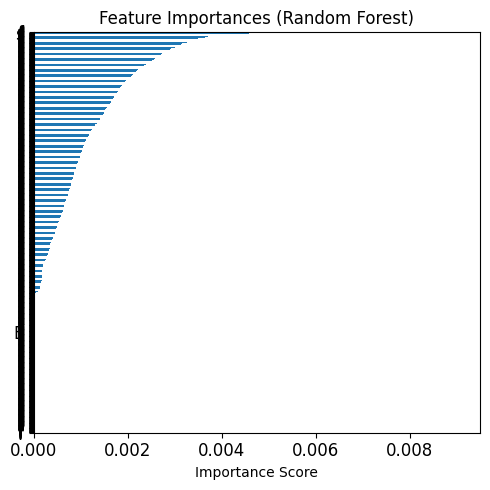

Select ids  while keeping the age/sex group same

In [ ]:

# Just the IDs

sampled_ids = participants['participant_id'].tolist()

num_rows = participants.shape[0]
participants['age_group'] = pd.cut(participants['age.6'], bins=[5.0, 13.0, 18.0], labels=['5-13', '13-18'], right=False)
participants['strata'] = participants['sex.6'] + '_' + participants['age_group'].astype(str)
df_strat = participants.dropna(subset=['strata'])

# Stratified sampling
sampled_df, _ = train_test_split(
    df_strat,
    train_size=238,
    stratify=df_strat['strata'],
    random_state=42
)


In [ ]:
#RNN : 
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = Sequential([
#     SimpleRNN(32, return_sequences=False),
#     Dropout(0.3),
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid') 
# ])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                     epochs=10, batch_size=8)
# loss, acc = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {acc:.2f}")